# Import Packages

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gseapy
import os

## Read data into scanpy
* needs to be transposed first to be loaded properly
* load into scanpy object

In [2]:
def transpose_csv(csv_path, output_csv_path='transposed.csv', delimiter=','):
    # code copied from: https://stackoverflow.com/questions/7156539/how-do-i-transpose-pivot-a-csv-file-with-python-without-loading-the-whole-file
    import csv
    
    print("easter egg")

    transposed_iterator = zip(*csv.reader(open(csv_path)))
    with open(output_csv_path, 'w') as out:
        for row in transposed_iterator:
            out.write(delimiter.join(row) + '\n')

raw_file = "../GSE125881_raw.expMatrix.csv" # read in the file here, ../ means folder above
transposed_file = "expMatrix_transposed.csv" #we needed to transpose the axes of the file
figpath = '../figures' #ATB, I am trying to save figures as I go?

if not os.path.exists(transposed_file):
    transpose_csv(raw_file, transposed_file)

In [3]:
# we see 62k cells and 20k genes
expr = sc.read_csv(transposed_file, first_column_names=True)

In [4]:
# save
#expr.write_h5ad("expr_raw.h5ad")

## Quality Control
* filter cells with < 200 genes
* filter genes with < 3 cells
* filter cells with > 10% mitochodrial genes

In [5]:
expr.var['mt'] = expr.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(expr, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#expr.obs.head()

In [6]:
#figure settings
sc.settings.set_figure_params(dpi_save = 80, dpi = 80, fontsize=18)
sc.settings.figdir = figpath

In [7]:
# n_genes_by_counts: Number of genes expressed in each cell (we filter out those with < 200)
# pct_counts_mt: Percentage of reads in each cell that are mitochondrial
# also filter out cells with >10% mitochondrial reads
sc.pp.filter_cells(expr, min_genes=200)

In [8]:
sc.pp.filter_genes(expr, min_cells=3)

In [9]:
expr = expr[expr.obs.n_genes_by_counts > 200,]
expr = expr[expr.obs.pct_counts_mt < 10,]

In [11]:
#heads up, this one takes a while to run. I silenced it so I dont run it and crash my computer
#sc.pl.violin(expr, ['n_genes_by_counts', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## Normalization
* normalize data to log(CPM+1)
* look at highly variable genes
* scale normalize the data

In [12]:
sc.pp.normalize_total(expr)
sc.pp.log1p(expr)
expr.raw = expr 

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
# notice that most of the high variable genes are TRB genes
sc.pp.highly_variable_genes(expr)
expr.var['trb'] = expr.var_names.str.startswith('TRB')
expr.var.loc[expr.var.highly_variable].sort_values("dispersions", ascending=False).head(10)

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,trb
S100A9,False,77,0.019689,99.876140,1224.0,77,True,0.013921,4.757143,14.140092,False
TRBV7-2,False,2294,0.481992,96.309939,29964.0,2294,True,0.377325,3.484430,8.916879,True
TRBV10-3,False,1090,0.326942,98.246658,20325.0,1090,True,0.281928,3.357422,8.565622,True
MTRNR2L12,False,58496,8.922001,5.905062,554654.0,58496,True,2.325795,3.318659,3.073340,False
LYZ,False,368,0.034472,99.408046,2143.0,368,True,0.022269,3.287997,9.632686,False
TRBV7-3,False,1243,0.280921,98.000547,17464.0,1243,True,0.243818,3.256322,8.286018,True
TRBV4-1,False,2035,0.489408,96.726559,30425.0,2035,True,0.405404,3.205354,8.145060,True
TRBV11-2,False,2305,0.617900,96.292245,38413.0,2305,True,0.462127,3.176631,8.065622,True
TRBV12-3,False,1589,0.389178,97.443982,24194.0,1589,True,0.329502,3.121294,7.912581,True
TRBV13,False,1036,0.254122,98.333521,15798.0,1036,True,0.204568,3.077064,8.985533,True


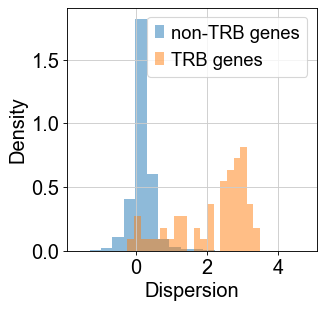

In [14]:
sc.settings.set_figure_params(dpi_save = 40, dpi = 40, fontsize=18)
plt.hist(data=expr.var.loc[~expr.var.trb], x="dispersions", label="non-TRB genes", density=True, alpha=0.5, bins=20)
plt.hist(data=expr.var.loc[expr.var.trb], x="dispersions", label="TRB genes", density=True, alpha=0.5, bins=20)
plt.xlabel("Dispersion")
plt.ylabel("Density")
plt.legend()
plt.show()

#first check, non-TRB should normally distribute around 0, TRB should skew between 2-4

In [15]:
sc.pp.scale(expr, max_value=10)

# Visualize EXPR clusters

In this section, we run the Scanpy principal component analysis, and then visualize clusters. I also look at each cluster with a stacked violin plot to check immunophenotypes and confirm CD8+ T cell identity.

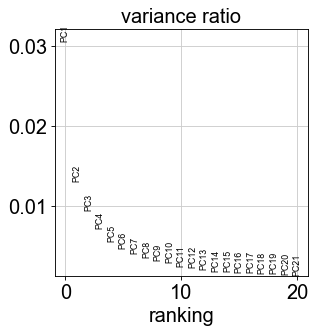

In [16]:
sc.tl.pca(expr)
sc.pl.pca_variance_ratio(expr, n_pcs=20)

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


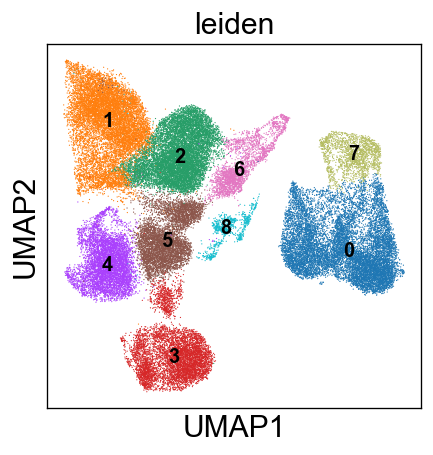

In [17]:
sc.settings.set_figure_params(dpi_save = 120, dpi = 60, fontsize=18)
sc.pp.neighbors(expr, n_pcs=15)
sc.tl.leiden(expr, resolution=0.2)
sc.tl.umap(expr)
fig = sc.pl.umap(expr, color=['leiden'],
                legend_fontsize = 12,
                legend_loc = 'on data')

In [18]:
#These are genes for checking several hematopoetic lineages
genes_to_plot = ["PTPRC", #Pan-Lukeocyte
                 "CD3E",  #Pan-T Cell
                 "CD4",   #Helper T Cell
                 "CD8A",  #Cytotoxic T Cell
                 "CD8B",  #Cytotoxic T Cell
                 "TRDC",  #gd T Cell
                 "NCAM1", #NK Cell
                 "NCR1",  #NK Cell
                 "CD19",  #B Cells
                 "ITGAM", #Pan-Myeloid
                 "CD68",  #Macrophage
                 "FUT4"]  #Neutrophils

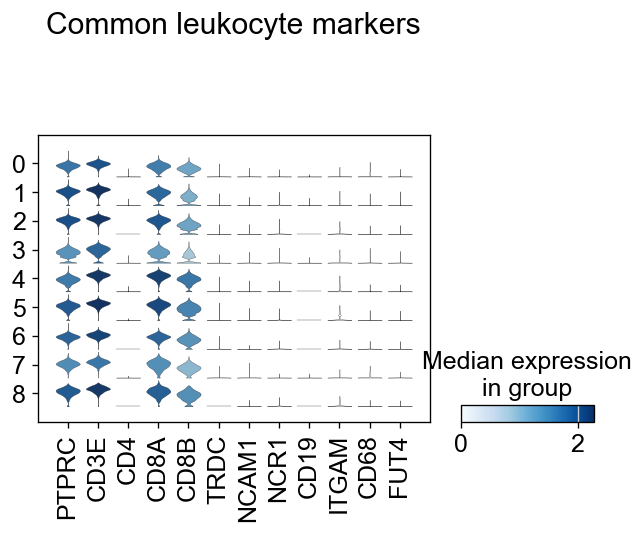

In [19]:
#Checking general phenotypes
sc.pl.stacked_violin(expr, genes_to_plot, groupby='leiden', title = "Common leukocyte markers", swap_axes=False)
plt.show()

In [20]:
print(os.getcwd())
gene_md = "../GSE125881_raw.expMatrix.csv"

/Users/aburden/Desktop/TCR_Project_DESK/CAR_T_clonal_kinetics_legacy


# Match barcode data with metadata and visualized based on sample info

In [21]:
meta = pd.read_csv("../geo_metadata.csv")

id_to_timepoint_type = dict(zip(meta["id_in_expmatrix"].astype(str), meta["time_point_type"]))
id_to_disease_state = dict(zip(meta["id_in_expmatrix"].astype(str), meta["disease_state"]))
id_to_patient_id = dict(zip(meta["id_in_expmatrix"].astype(str), meta["patient_id"]))
#meta.head(10)

In [22]:
expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]
expr.obs["disease_state"] = expr.obs["sample_id"].map(id_to_disease_state)
expr.obs["time_point_type"] = expr.obs["sample_id"].map(id_to_timepoint_type)
expr.obs["patient_id"] = expr.obs["sample_id"].map(id_to_patient_id)
expr.obs["patient_timepoint"] = expr.obs["patient_id"] + "-" + expr.obs["time_point_type"]
expr.obs["status"] = expr.obs["patient_id"].map(dict(zip(meta["patient_id"], meta["DFS/PFS_Status"])))

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


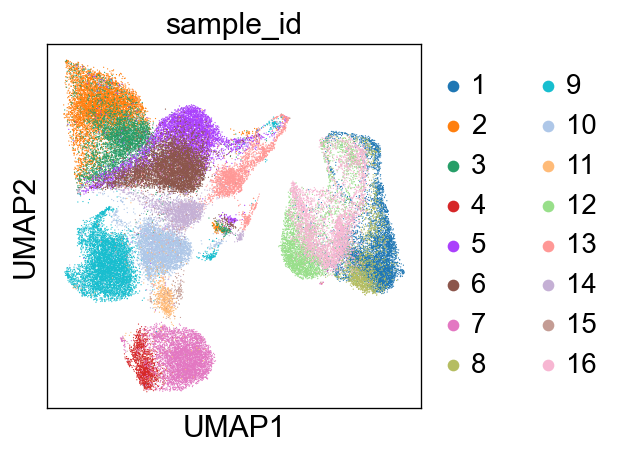

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


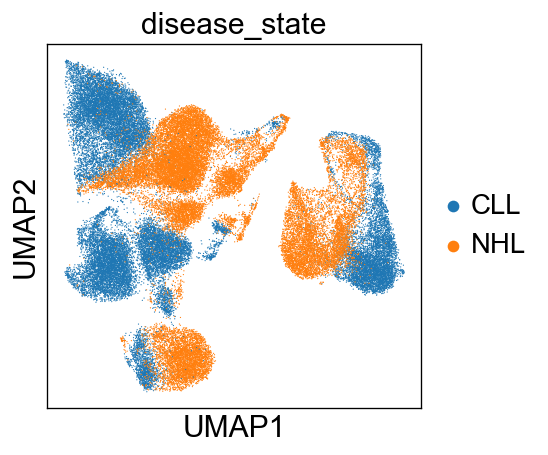

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


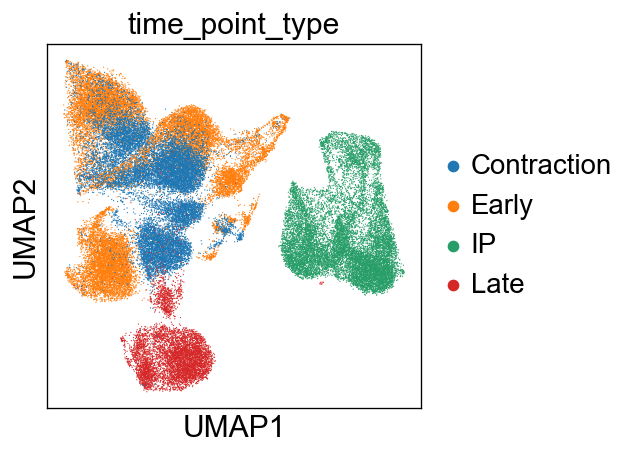

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


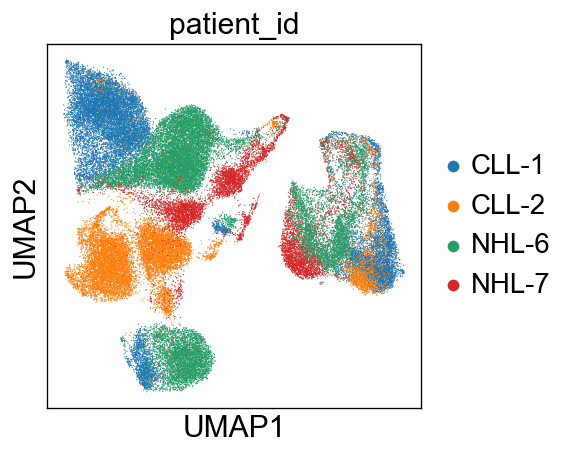

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


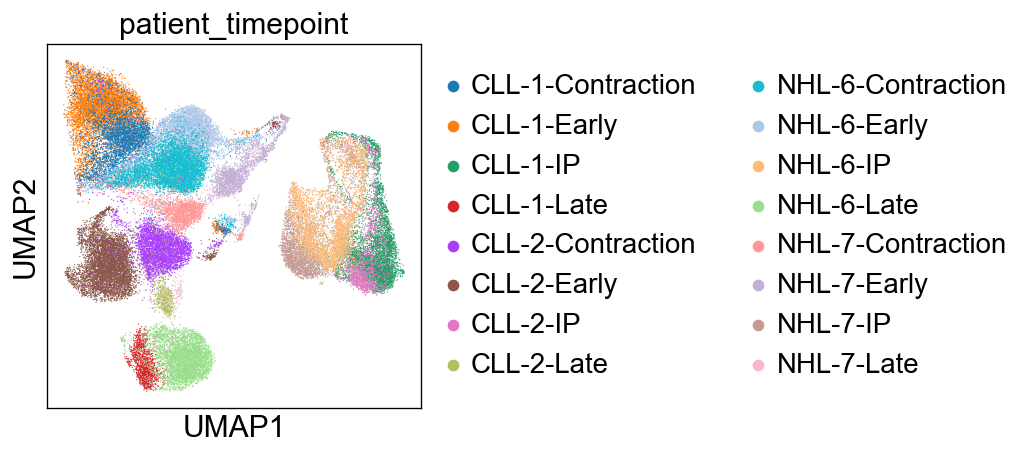

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


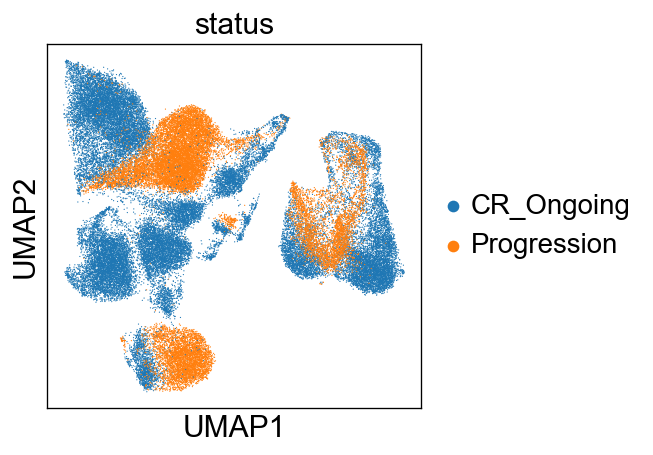

In [23]:
sc.pl.umap(expr, color="sample_id")
sc.pl.umap(expr, color="disease_state")
sc.pl.umap(expr, color="time_point_type")
sc.pl.umap(expr, color="patient_id")
sc.pl.umap(expr, color="patient_timepoint")
sc.pl.umap(expr, color="status")

# Differential Expression & Heatmaps
* for a given patient how does gene expression change over time?
    * compare Early, Contraction, and Late to IP
    * do GSEA btwn E,C,L and IP
    
First, I was trying to determine which statistical test to run. I ran stats for T-Test, T-test ov_var, and Wilcoxon.
    
The below code is derived from: https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html

## T-test

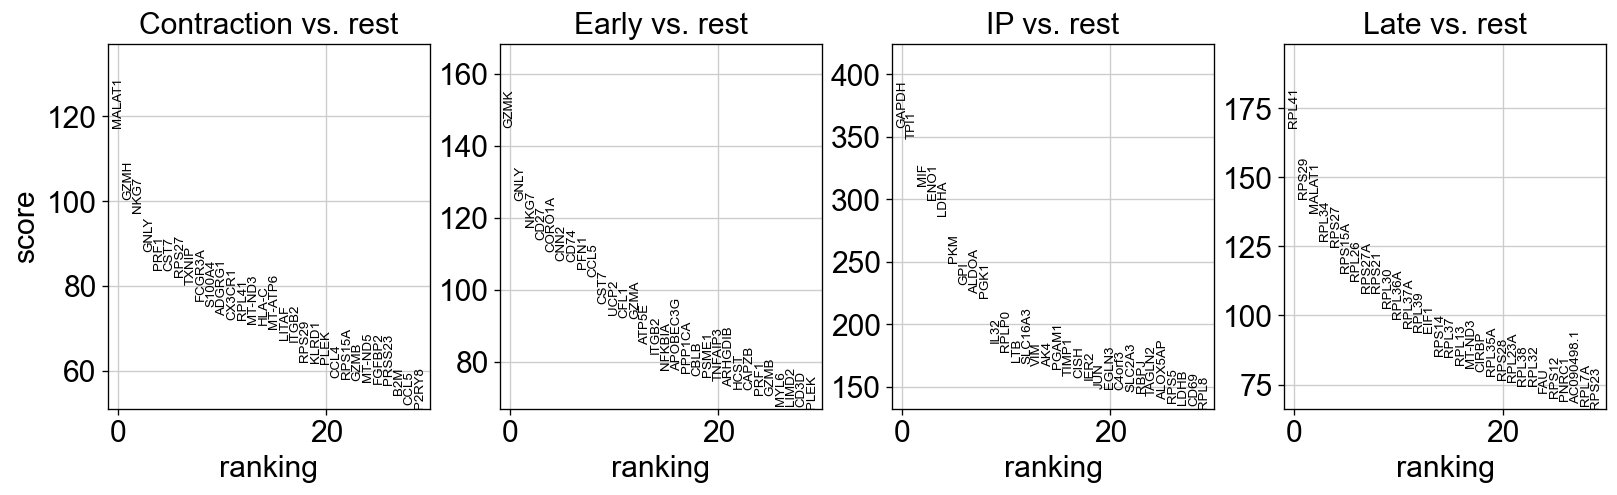

In [24]:
sc.tl.rank_genes_groups(expr, "time_point_type", method = 't-test', key_added = 't-test')
sc.pl.rank_genes_groups(expr, n_genes=30, sharey=False, key = 't-test')

In [25]:
#results are stored in the adata.uns['t-test'] slot
expr

AnnData object with n_obs × n_vars = 57122 × 20107
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'sample_id', 'disease_state', 'time_point_type', 'patient_id', 'patient_timepoint', 'status'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'trb', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'sample_id_colors', 'disease_state_colors', 'time_point_type_colors', 'patient_id_colors', 'patient_timepoint_colors', 'status_colors', 't-test'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## T-test overestimated_variance

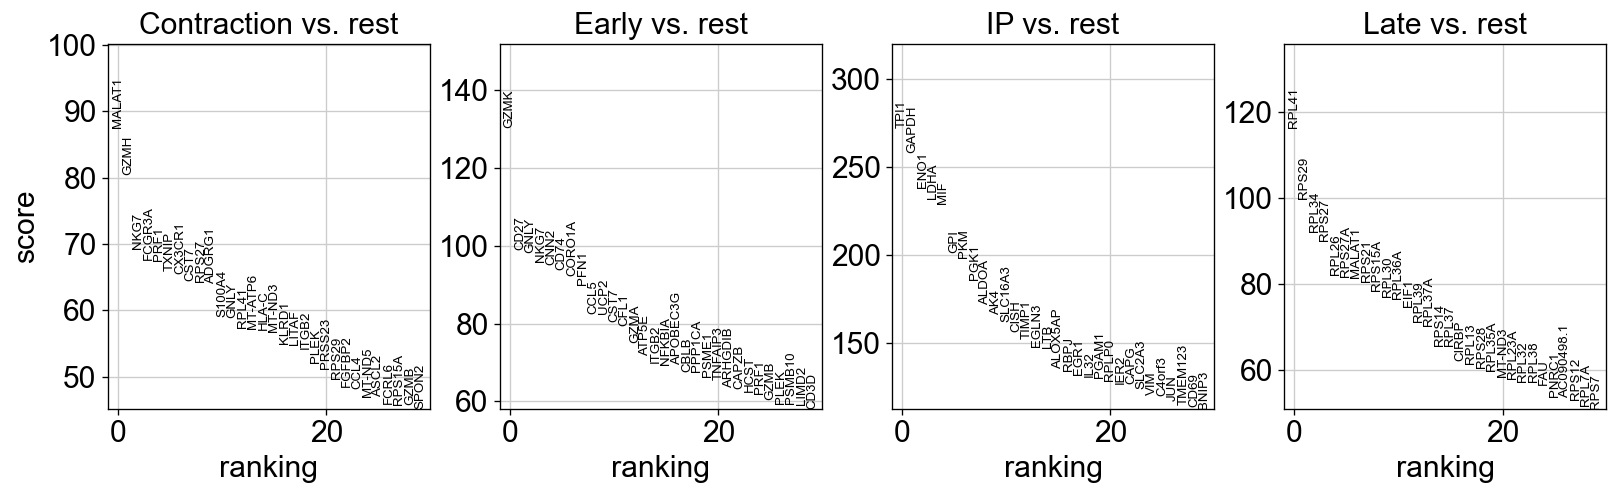

In [26]:
sc.tl.rank_genes_groups(expr, "time_point_type", method = 't-test_overestim_var', key_added ="t-test_ov")
sc.pl.rank_genes_groups(expr, n_genes=30, sharey=False, key = 't-test_ov')

## Wilcoxon rank-sum

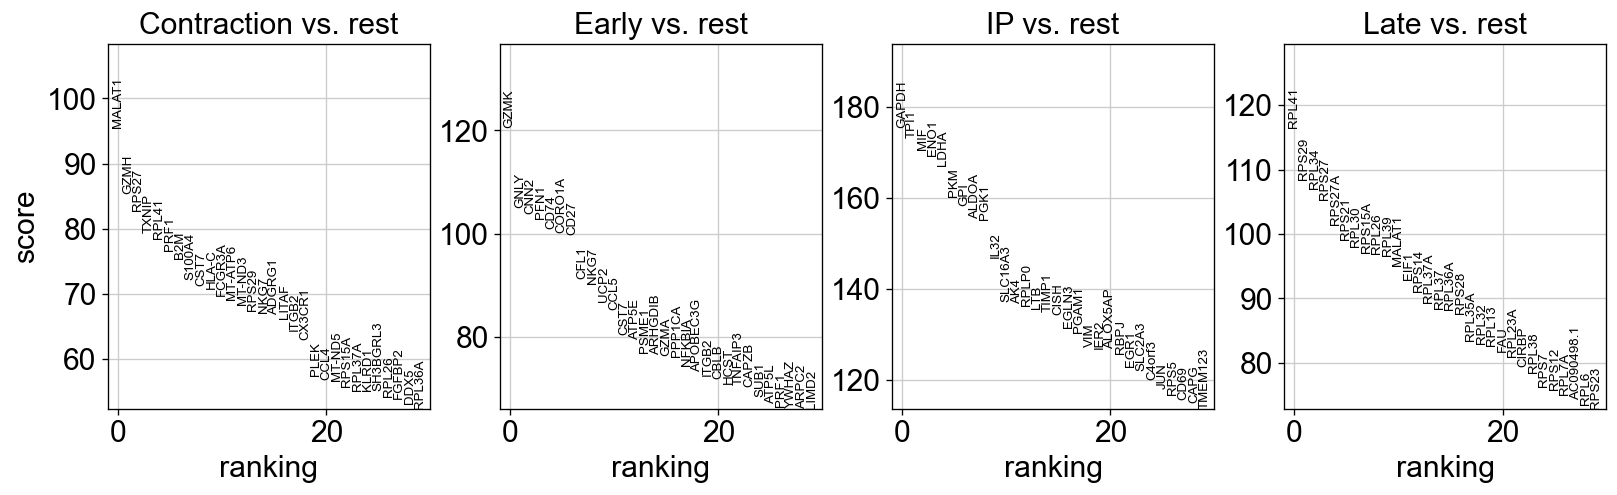

In [28]:
sc.tl.rank_genes_groups(expr, "time_point_type", method = 'wilcoxon', key_added = 'wilcoxon')
sc.pl.rank_genes_groups(expr, n_genes = 30, sharey=False, key = "wilcoxon")

## Logistic Regression Test

In [29]:
#I also wanted to run a logistic regression test, but this would take so long my computer would crash. Keep silenced

#sc.tl.rank_genes_groups(expr, 'time_point_type', method = 'logreg', key_added = 'logreg')
#sc.pl.genes_groups(expr, n_genes = 30, sharey=False, key = 'logreg')

# Compare Genes & Data Distributiion

I have now added columns with statistic values from the above code. Below, I ploted the number of overlapping statistically significant genes between the different testing methods using a venn diagram. Then, I looked at the overall distribution of data, which is skewed. Thus, it is best to continue using the Wilcoxon statistics for differential gene expression analysis. 

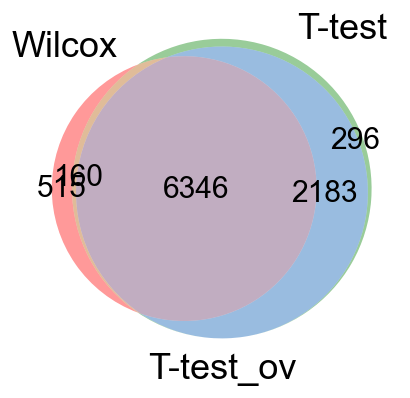

In [30]:
#compare culster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(expr, group='IP', key = 'wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(expr, group='IP', key = 't-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(expr, group='IP', key = 't-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3 #make sure matplotlib_venn is installed separate from matplotlib

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox', 'T-test', 'T-test_ov'))
plt.show()

#KeyError: "None of [Index(['0'], dtype='object')] are in the [columns]"

/var/folders/73/tp0xvqbs5s72vwdcn0422xt40000gq/T/ipykernel_92957/1401294845.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/73/tp0xvqbs5s72vwdcn0422xt40000gq/T/ipykernel_92957/1401294845.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

<Axes: xlabel='n_genes_by_counts'>

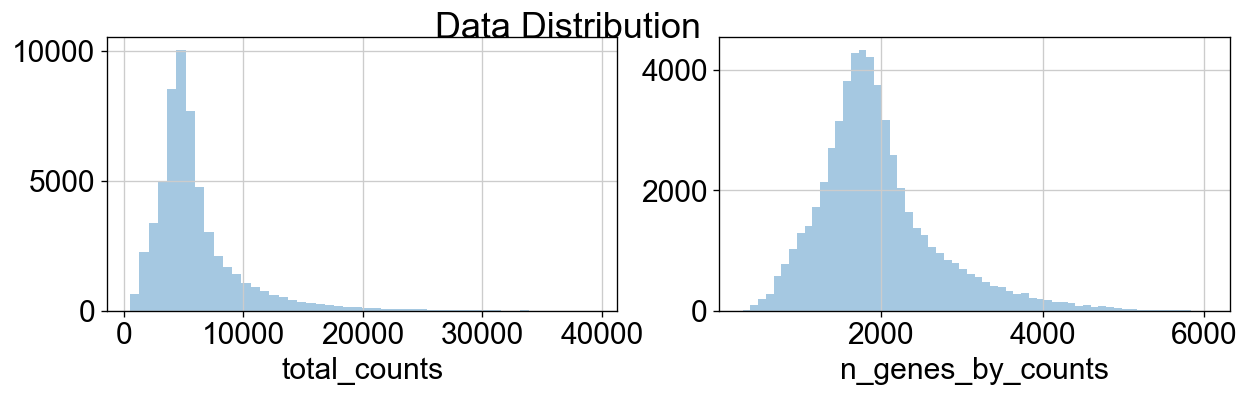

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
fig.suptitle("Data Distribution")
    
adata = expr
    
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])


# Visualization

I visualized the differentially expressed genes between timepoints by each type of clinical metadata.

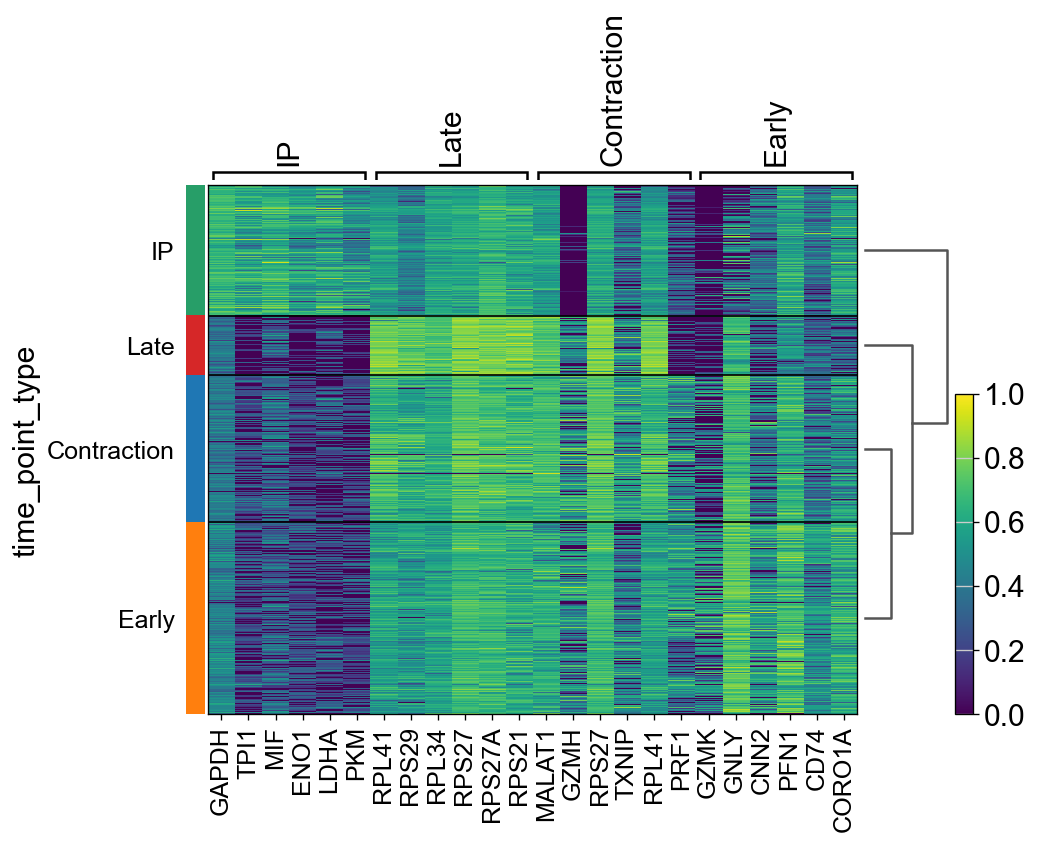

In [34]:
sc.pl.rank_genes_groups_heatmap(expr, n_genes = 6, 
                                key="wilcoxon", 
                                groupby="time_point_type",
                                standard_scale = 'var',
                                show_gene_labels=True, 
                                swap_axes=False)

categories: CLL-1, CLL-2, NHL-6, etc.
var_group_labels: Contraction, Early, IP, etc.


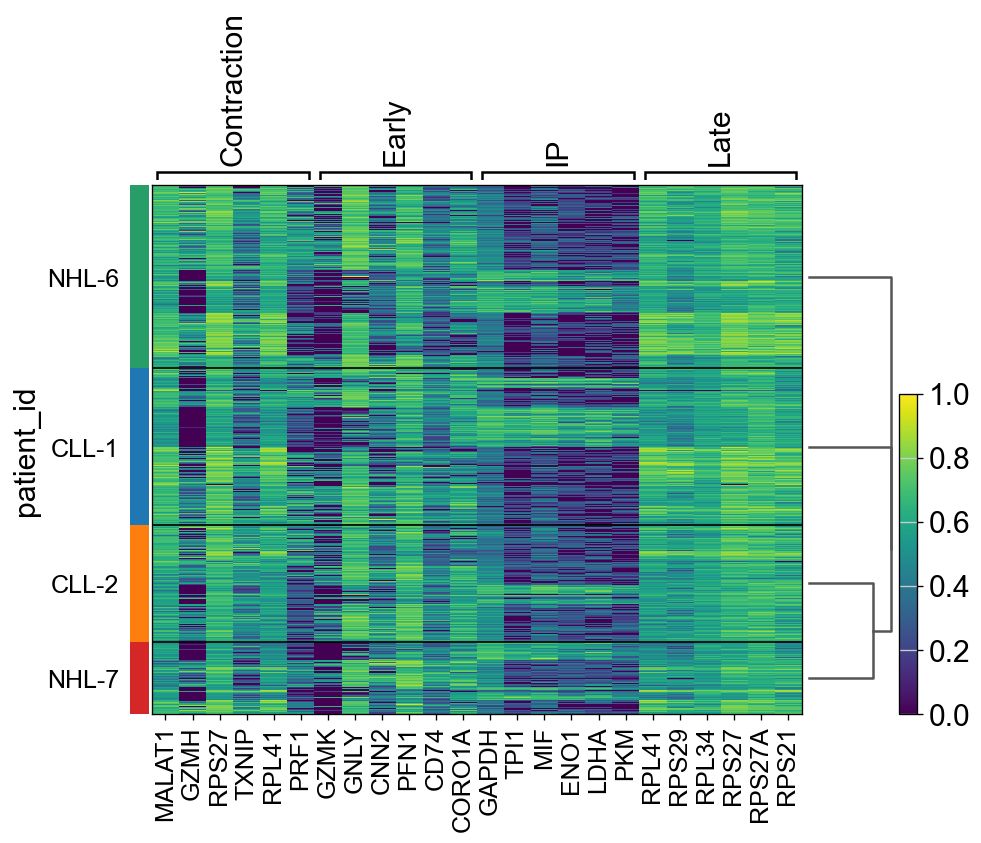

In [35]:
sc.pl.rank_genes_groups_heatmap(expr, n_genes = 6, 
                                key="wilcoxon", 
                                groupby="patient_id",
                                standard_scale = 'var',
                                show_gene_labels=True, 
                                swap_axes=False)


categories: CLL, NHL
var_group_labels: Contraction, Early, IP, etc.


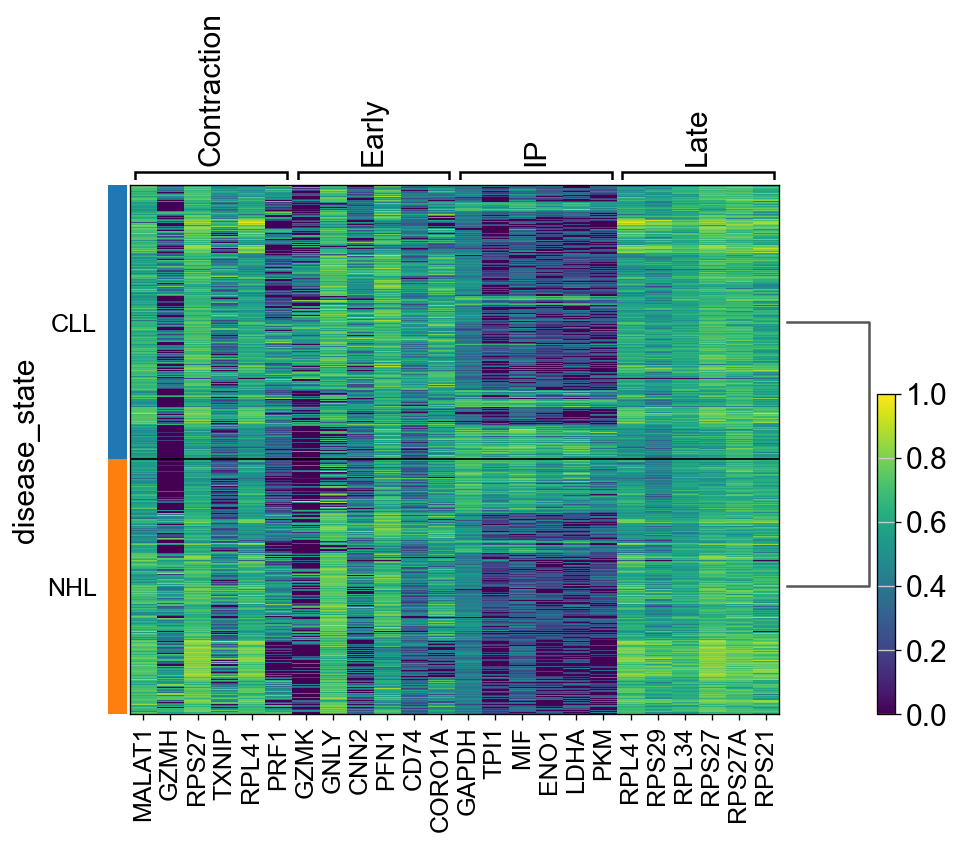

In [36]:
sc.pl.rank_genes_groups_heatmap(expr, n_genes = 6, 
                                key="wilcoxon", 
                                groupby="disease_state",
                                standard_scale = 'var',
                                show_gene_labels=True, 
                                swap_axes=False)


categories: CLL-1-Contraction, CLL-1-Early, CLL-1-IP, etc.
var_group_labels: Contraction, Early, IP, etc.


/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


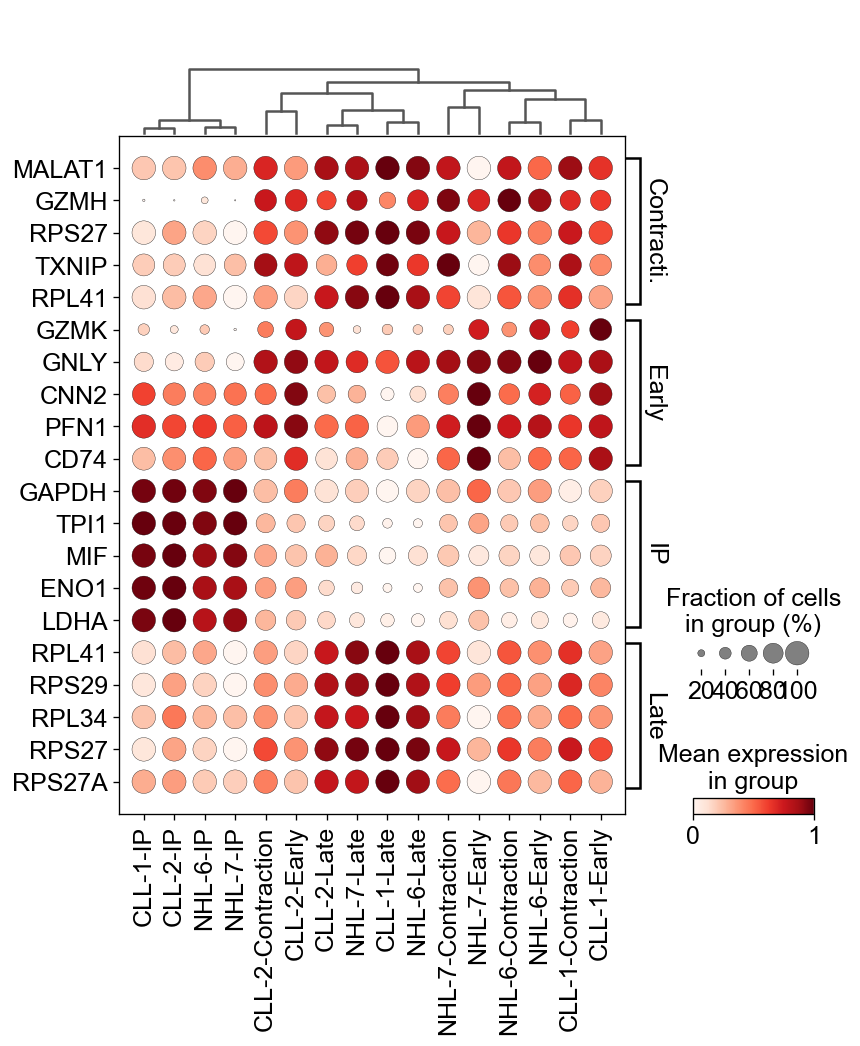

In [37]:
sc.pl.rank_genes_groups_dotplot(expr, n_genes=5, key='wilcoxon', standard_scale = 'var', groupby='patient_timepoint', swap_axes=True)
#This plot was not used in the presentation or report

# Gene Set Analysis

Code below looks at gene set enrichment analysis for IP timepoint. The first of the figures was included in the report and presentation, although the second figure is only included in the presentation supplemental figures. 

Having a defined list of differentially expressed genes, you can now look for their combined function using hypergeometric test:

In [60]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
#I used the Human database
gene_set_names = gseapy.get_library_name(organism='Human')

In [61]:
#get the significant DEGs
#Here I looked at the top DEGs in IP and determined the gene pathway enrichment
glist = sc.get.rank_genes_groups_df(expr, group='IP', 
                                    key='wilcoxon', log2fc_min=0.25, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
print(len(glist))

5975


In [62]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2018',
                     cutoff = 0.5)

<Axes: title={'center': 'GO_Biological_Process_2018'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

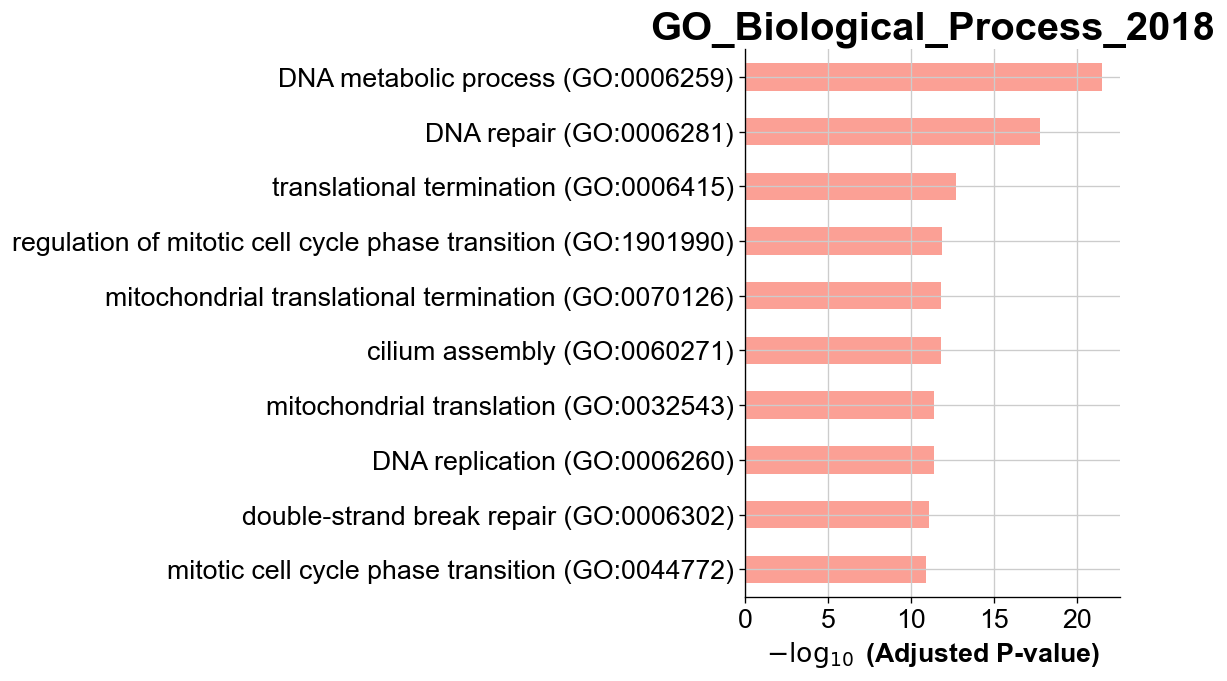

In [63]:
gseapy.barplot(enr_res.res2d, top_term = 10, title='GO_Biological_Process_2018') 

In [64]:
#Here I labeled variables for certain timepoints and stat types
group1 = 'IP'
method = 'wilcoxon'


gene_rank_1 = sc.get.rank_genes_groups_df(expr, group=group1, key=method)[['names','logfoldchanges']]
gene_rank_1.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

In [65]:
# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(expr, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank_1 = gene_rank_1[gene_rank_1['names'].isin(expr.var_names[expr.var.n_cells_by_counts>30])]

In [66]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')

In [67]:
res_1 = gseapy.prerank(rnk=gene_rank_1, gene_sets='KEGG_2021_Human')

2023-03-19 20:14:40,145 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [68]:
terms_1 = res_1.res2d.Term
terms_1[:10]

0                      Arginine and proline metabolism
1         Metabolism of xenobiotics by cytochrome P450
2                           Inflammatory bowel disease
3                                   Pathways in cancer
4                                      Drug metabolism
5                         Steroid hormone biosynthesis
6    Endocrine and other factor-regulated calcium r...
7               Cytokine-cytokine receptor interaction
8                              beta-Alanine metabolism
9                    B cell receptor signaling pathway
Name: Term, dtype: object

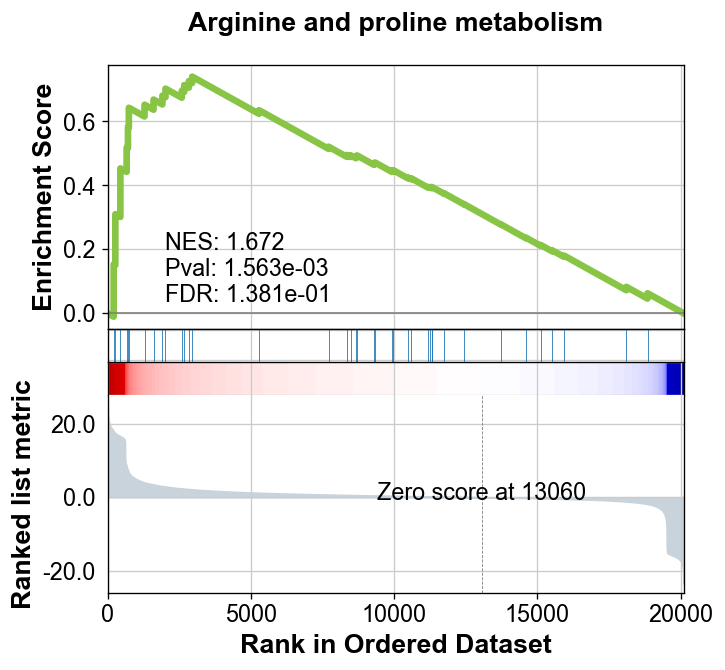

In [69]:
gseapy.gseaplot(rank_metric=res_1.ranking, term=terms_1[0], **res_1.results[terms_1[0]])

# Supplemental Code & figures

Below I have included code for vestigle analyses and figures. Nothing below is used in any presentation or report for the STEMREM 205 class; however, I did not want to abandon the code, so I appended it to this document. 

## Differential expression across conditions

In [46]:
#group_0 = expr[expr.obs['leiden'] == '0',:]
#group_7 = expr[expr.obs['leiden'] == '7',:]
#group_8 = expr[expr.obs['leiden'] == '8',:]

#group_8.obs.value_counts()

In [60]:
#ranking genes
#sc.tl.rank_genes_groups(subset, "status", method = 'wilcoxon', key_added = "wilcoxon")
#sc.pl.rank_genes_groups(subset, n_genes=25, sharey=False, key='wilcoxon')

In [61]:
#sc.pl.rank_genes_groups_violin(subset, n_genes=10, standard_scale = 'var', key="wilcoxon", key='True', jitter = True)

In [47]:
#genes1 = sc.get.rank_genes_groups_df(subset, group='CR_Ongoing', key='wilcoxon')['names'][:5]
#genes2 = sc.get.rank_genes_groups_df(subset, group='Progression', key='wilcoxon')['names'][:5]
#genes = genes1.tolist() +  genes2.tolist() 
#df = sc.get.obs_df(expr, genes + ['time_point_type','status'], use_raw=False)
#df2 = df.melt(id_vars=["time_point_type",'status'], value_vars=genes)

In [48]:
#sns.catplot(x = "time_point_type", y = "value", hue = "status", kind = 'violin', 
#               col = "variable", data = df2, col_wrap=4, inner=None)

## QC for TCR data
* ensure each barcode is associated with only 1 clonotype
* TODO: figure out how to create mapping from barcodes to clonotypes

In [29]:
# read in 1 sample TCR dataframe
ex_tcr_df = pd.read_csv("GSE125881_RAW/GSM3583877_CLL-1_IP-unpaired-clonotypes.csv.gz", compression="gzip", sep=",")

In [32]:
ex_tcr_df.head()

,chain,clonotype_ids,consensus_ids,barcodes,contig_ids,cdr3s,cdr3_nts,v_genes,d_genes,j_genes,c_genes,frequency,proportion
0,TRB,clonotype1;clonotype5;clonotype1799;clonotype4...,clonotype1_consensus_1;clonotype5_consensus_1;...,AAACGGGCACGTAAGG-1;CTCGTCATCTGTTGAG-1;CTGCGGAC...,AAACGGGCACGTAAGG-1_contig_1;AAACGGGGTCCTCCAT-1...,CASSPNQHSGANVLTF,TGTGCCAGCTCACCGAACCAGCACTCTGGGGCCAACGTCCTGACTTTC,TRBV18,TRBD2,TRBJ2-6,TRBC1;TRBC2,150,0.027634
1,TRA,clonotype1;clonotype1799;clonotype4166;clonoty...,clonotype1_consensus_2;clonotype1799_consensus...,ACCGTAAGTTGTGGAG-1;GGTGTTAGTATCAGTC-1;CACACAAG...,AAACGGGCACGTAAGG-1_contig_4;AAACGGGGTCCTCCAT-1...,CLVGDMRTGGGNKLTF,TGCCTCGTGGGTGACATGAGAACGGGAGGAGGAAACAAACTCACCTTT,TRAV4,NaN,TRAJ10,TRAC,126,0.022573
2,TRB,clonotype2;clonotype18;clonotype952;clonotype2...,clonotype2_consensus_1;clonotype18_consensus_1...,GACGTGCAGGATGGAA-1;GATGAAAAGGGTGTTG-1;GATGAGGT...,AACTGGTGTCTTCAAG-1_contig_1;AACTGGTGTTGAGGTG-1...,CSVEGVWQGTTNSGNTIYF,TGCAGCGTTGAAGGAGTGTGGCAGGGGACTACCAACTCTGGAAACA...,TRBV29-1,TRBD2,TRBJ1-3,TRBC1,112,0.020634
3,TRA,clonotype2;clonotype65;clonotype952;clonotype2...,clonotype2_consensus_2;clonotype65_consensus_1...,GACGTGCAGGATGGAA-1;TGCACCTGTTTAGGAA-1;AAGGCAGC...,AACTGGTGTCTTCAAG-1_contig_3;AACTGGTGTTGAGGTG-1...,CAVRALGGATNKLIF,TGTGCTGTGAGAGCCCTGGGTGGTGCTACAAACAAGCTCATCTTT,TRAV3,NaN,TRAJ32,TRAC,104,0.018631
4,TRA,clonotype3;clonotype441;clonotype1948;clonotyp...,clonotype3_consensus_1;clonotype441_consensus_...,GCAAACTAGTCACGCC-1;AGTGGGATCGGTCTAA-1;ATCTACTG...,AAACGGGTCCTAGTGA-1_contig_2;AAATGCCTCGTCTGCT-1...,CAPDSSYKLIF,TGTGCCCCCGATAGCAGCTATAAATTGATCTTC,TRAV17,NaN,TRAJ12,TRAC,95,0.017019


In [33]:
# Investigate whether the first two rows are the TCRB and TCRA barcodes associated with the same clonotype

example_tcrb_barcodes = set(ex_tcr_df.loc[0,"barcodes"].split(";")) 
example_tcra_barcides = set(ex_tcr_df.loc[1,"barcodes"].split(";"))

print(f"There are {len(example_tcrb_barcodes - example_tcra_barcides)} TCRB barcodes that are not in the TCRA barcodes")
print(f"There are {len(example_tcra_barcides - example_tcrb_barcodes)} TRCA barcodes that are not in the TCRB barcodes")

There are 24 TCRB barcodes that are not in the TCRA barcodes
There are 0 TRCA barcodes that are not in the TCRB barcodes


In [35]:
# Investigate whether there is a one-to-one mapping between 'clonotype ids' and 'barcodes' in a given row
# Seems likethere is not as there are way more barcodes than clonotypes
print(f"There are {len(ex_tcr_df.loc[0,'clonotype_ids'].split(';'))} clonotypes ids in the 0th row")
print(f"There are {len(ex_tcr_df.loc[0,'barcodes'].split(';'))} barcodes in the 0th row")

There are 11 clonotypes ids in the 0th row
There are 150 barcodes in the 0th row


# DGE and GSEA for leiden
## Subsample
So one obvious thing to consider is an equal amount of cells per individual so that the DGE results are not dominated by a single sample.

So we will downsample to an equal number of cells per sample.

In [70]:
#short_list = sc.tl.rank_genes_groups(expr, "leiden", method = 'wilcoxon', key_added = 'wilcoxon')
#sc.pl.rank_genes_groups(expr, n_genes = 30, sharey=False, key = "wilcoxon")

In [71]:
#sc.pl.rank_genes_groups_heatmap(expr, n_genes = 5, 
#                                key="wilcoxon", 
#                                groupby="leiden",
#                                standard_scale = 'var',
#                                show_gene_labels=True, 
#                                swap_axes=False)

In [72]:
#group_8 = [ 'TRBV7-4', 
#              'TRBV7-6', 
#              'TRBV7-7', 
#              'TRBV7-9', 
#              'TRBV7-2']

#group_0 = ['TPI1', 
#              'MIF', 
#              'ENO1', 
#              'LDHA', 
#              'PFN1'] 

             
#group_7 = ['TUBB', 
#              'TUBA1B', 
#              'STMN1', 
#              'MKI67', 
#              'H2AFZ']

In [73]:
#sc.settings.set_figure_params(dpi_save = 40, dpi = 80, fontsize=18)
#sc.pl.stacked_violin(expr, group_8, groupby='leiden', title = "group 8", legend_loc=None, swap_axes=False)
#plt.show()

In [74]:
#sc.pl.stacked_violin(expr, group_0, groupby='leiden', title = "group 0", legend=None, swap_axes=False)
#plt.show()

In [75]:
#sc.pl.stacked_violin(expr, group_7, groupby='leiden', title = "group 7", swap_axes=False)
#plt.show()

In [76]:
#subset the individual dataset to the variable genes we defined at the beginning

#group_0 = expr[expr.obs['leiden'] == '0',:]
#group_7 = expr[expr.obs['leiden'] == '7',:]
#group_8 = expr[expr.obs['leiden'] == '8',:]

#search_list = group_7

In [77]:
#GSEA Gene Ranking 

#gene_rank_group_0 = sc.get.rank_genes_groups_df(expr, group=group_0, key=method)[['names','logfoldchanges']]
#gene_rank_group_0.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

#gene_rank_group_7 = sc.get.rank_genes_groups_df(expr, group=group_7, key=method)[['names','logfoldchanges']]
#gene_rank_group_7.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

#gene_rank_group_8 = sc.get.rank_genes_groups_df(expr, group=group1, key=method)[['names','logfoldchanges']]
#gene_rank_group_8.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)


In [81]:
#define subsets
#group_0.obs['leiden'].value_counts()

In [ ]:
#This will standardize the number of cells for DGE analysis
#target_cells = 150

#tmp = [subset[subset.obs[var1] == s] for s in subset.obs[var1].cat.categories]

#for dat in tmp:
#    if dat.n_obs > target_cells:
#         sc.pp.subsample(dat, n_obs=target_cells)

#subset_sub = tmp[0].concatenate(*tmp[1:])

#subset_sub.obs[var1].value_counts()

In [79]:
#sc.tl.rank_genes_groups(subset_sub, var_type, method=method, key_added = method)
#sc.pl.rank_genes_groups(subset_sub, n_genes=25, sharey=False, key=method)

In [80]:
#genes1 = sc.get.rank_genes_groups_df(subset_sub, group=group1, key=method)['names'][:20]
#genes2 = sc.get.rank_genes_groups_df(subset_sub, group=group2, key=method)['names'][:20]
#genes = genes1.tolist() +  genes2.tolist() 

#sc.pl.dotplot(subset,genes, groupby='time_point_type')